In [122]:
import numpy as np
import pandas as pd
import anndata as ad
from sklearn.preprocessing import StandardScaler
import sys
sys.path.insert(0, '/Users/luosanj/Desktop/project2/CelLink')
import metric
from model import Cellink
import scanpy as sc

def simulate_multimodal_data(
    n_cells=100000,
    n_cell_types=5,
    n_linked_features=100,
    n_d1_unique=5000,
    n_d2_unique=20,
    linked_correlation=0.9,
    cell_type_similarity_matrix=None,
    markers_per_celltype=2,
    random_seed=42
):
    """
    Simulate paired scd1-seq and d2 data with:
    - Linked features with controlled correlations
    - Cell-type specific markers
    - Controlled similarity between cell types
    - Individual cell variation within each cell type
    
    Parameters
    ----------
    cell_type_similarity_matrix : np.ndarray, optional
        Matrix of shape (n_cell_types, n_cell_types) specifying similarity
        between cell types. Values should be between 0 and 1.
        If None, defaults to identity matrix (no similarity between different types)
    """
    np.random.seed(random_seed)
    
    # Set up cell type similarity matrix if not provided
    if cell_type_similarity_matrix is None:
        cell_type_similarity_matrix = np.eye(n_cell_types)
    
    # Generate cell type assignments
    cell_types = np.random.choice(range(n_cell_types), size=n_cells)
    
    # Generate cell type centers in latent space
    n_latent = 20
    celltype_centers = {
        ct: np.random.normal(0, 1, size=(n_latent,))
        for ct in range(n_cell_types)
    }
    
    # Generate cell-specific latent variables
    z = np.zeros((n_cells, n_latent))
    for i, cell_type in enumerate(cell_types):
        # Start with cell type center
        z[i] = celltype_centers[cell_type]
        
        # Add cell-specific variation
        cell_variation = np.random.normal(0, 0.2, size=(n_latent,))
        z[i] += cell_variation
        
        # Add contributions from other cell types based on similarity
        for other_ct in range(n_cell_types):
            if other_ct != cell_type:
                similarity = cell_type_similarity_matrix[cell_type, other_ct]
                if similarity > 0:
                    # Add weighted contribution from other cell type center
                    other_contribution = similarity * celltype_centers[other_ct]
                    z[i] += other_contribution
    
    # Normalize latent variables
    z = (z - np.mean(z, axis=0)) / np.std(z, axis=0)
    
    # Generate weight matrices
    W_linked = np.random.normal(0, 1, size=(n_latent, n_linked_features))
    W_d1_unique = np.random.normal(0, 1, size=(n_latent, n_d1_unique))
    W_d2_unique = np.random.normal(0, 1, size=(n_latent, n_d2_unique))
    
    # Generate base data
    linked_features_base = np.dot(z, W_linked)
    d1_unique_base = np.dot(z, W_d1_unique)
    d2_unique_base = np.dot(z, W_d2_unique)

    def generate_correlated_features(x, base_correlation, cell_types, similarity_matrix):
        # Standardize x
        x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
        
        # Initialize y with noise
        y = np.random.normal(0, 1, size=x.shape)
        
        # Adjust correlations for each cell type pair
        for ct1 in range(similarity_matrix.shape[0]):
            mask1 = cell_types == ct1
            
            # Apply correlation to matching cell type pairs
            y[mask1] = (base_correlation * x[mask1] + 
                           np.sqrt(1 - base_correlation**2) * np.random.normal(0, 1, size=x[mask1].shape))
        return x, y
    
    d1_linked_features, d2_linked_features = generate_correlated_features(
        linked_features_base, linked_correlation, cell_types, cell_type_similarity_matrix
    )
    
    # Add cell-type specific markers with individual cell variation
    marker_effect_size = 2.0
    for ct in range(n_cell_types):
        ct_mask = cell_types == ct
        
        # Add markers to linked features
        linked_markers = np.random.choice(range(n_linked_features), 
                                        markers_per_celltype, 
                                        replace=False)
        for marker in linked_markers:
            # Add cell-specific variation to marker effect
            effect = np.random.normal(marker_effect_size, 0.2, size=(np.sum(ct_mask)))
            d1_linked_features[ct_mask, marker] += effect
            d2_linked_features[ct_mask, marker] += linked_correlation * effect + np.sqrt(1 - linked_correlation**2) * np.random.normal(0, 1, size=(np.sum(ct_mask)))
        
    # Calculate correlations between d1 and d2 linked features
    correlation_matrix = np.corrcoef(d1_linked_features.T, d2_linked_features.T)[:n_linked_features, n_linked_features:]
    correlation_df = pd.DataFrame(
        correlation_matrix,
        columns=[f'd2_linked_feature_{i}' for i in range(n_linked_features)],
        index=[f'd1_linked_feature_{i}' for i in range(n_linked_features)]
    )

    
    # Create complete datasets
    d1_data = np.hstack([d1_linked_features, d1_unique_base])
    d2_data = np.hstack([d2_linked_features, d2_unique_base])
    
    # Create feature names
    linked_features = [f'linked_feature_{i}' for i in range(n_linked_features)]
    d1_unique_features = [f'd1_feature_{i}' for i in range(n_d1_unique)]
    d2_unique_features = [f'd2_feature_{i}' for i in range(n_d2_unique)]
    
    d1_features = linked_features + d1_unique_features
    d2_features = linked_features + d2_unique_features
    
    # Create cell metadata
    cell_metadata = pd.DataFrame({
        'cell_id': [f'cell_{i}' for i in range(n_cells)],
        'cell_type': [f'celltype_{ct}' for ct in cell_types]
    })
    
    # Create unscaled full datasets
    d1_df_full = pd.DataFrame(d1_data, columns=d1_features, index=cell_metadata['cell_id'])
    d2_df_full = pd.DataFrame(d2_data, columns=d2_features, index=cell_metadata['cell_id'])
    
    # Create and scale linked-feature-only datasets
    scaler = StandardScaler()
    d1_linked_scaled = pd.DataFrame(
        scaler.fit_transform(d1_data[:, :n_linked_features]),
        columns=linked_features,
        index=cell_metadata['cell_id']
    )
    d2_linked_scaled = pd.DataFrame(
        scaler.fit_transform(d2_data[:, :n_linked_features]),
        columns=linked_features,
        index=cell_metadata['cell_id']
    )
    
    # Create AnnData objects
    d1_adata = ad.AnnData(
        X=d1_df_full,
        obs=cell_metadata.set_index('cell_id'),
        var=pd.DataFrame(index=d1_features)
    )
    
    d2_adata = ad.AnnData(
        X=d2_df_full,
        obs=cell_metadata.set_index('cell_id'),
        var=pd.DataFrame(index=d2_features)
    )
    
    d1_shared = ad.AnnData(
        X=d1_linked_scaled,
        obs=cell_metadata.set_index('cell_id'),
        var=pd.DataFrame(index=linked_features)
    )
    
    d2_shared = ad.AnnData(
        X=d2_linked_scaled,
        obs=cell_metadata.set_index('cell_id'),
        var=pd.DataFrame(index=linked_features)
    )
    
    # Add simulation parameters to uns
    simulation_params = {
        'n_cells': n_cells,
        'n_cell_types': n_cell_types,
        'n_linked_features': n_linked_features,
        'n_d1_unique': n_d1_unique,
        'n_d2_unique': n_d2_unique,
        'linked_correlation': linked_correlation,
        'random_seed': random_seed
    }
    
    for adata in [d1_adata, d2_adata, d1_shared, d2_shared]:
        adata.uns['simulation_params'] = simulation_params
    
    return {
        'd1_adata': d1_adata,
        'd2_adata': d2_adata,
        'd1_shared': d1_shared,
        'd2_shared': d2_shared,
        'corr_unscaled': correlation_df
    }

In [99]:
# Validation
import time
if __name__ == "__main__":
    # Create a sample similarity matrix
    n_types = 5
    similarity_matrix = np.eye(n_types)
    # High similarity between types 0 and 1
    similarity_matrix[0, 1] = similarity_matrix[1, 0] = 0.8
    # Medium similarity between types 2 and 3
    similarity_matrix[2, 3] = similarity_matrix[3, 2] = 0.5
    # Low similarity between types 3 and 4
    similarity_matrix[3, 4] = similarity_matrix[4, 3] = 0.3
    
    impute_corr = np.zeros(shape = [2, 10])
    ct_acc = np.zeros(shape = [2, 10])
    time_loop = np.zeros(shape = (10,))
    
    dict_unscaled_feature_corr = {}
    
    for i in range(0, 10):
        corr = i / 10
        print(f'corr:{corr}\n')
    
        data = simulate_multimodal_data(
            n_cells=10000,
            cell_type_similarity_matrix=similarity_matrix,
            linked_correlation= corr
        )
        
        # Calculate correlations per cell type
        shared_features = data['d1_shared'].var_names
        cell_types = data['d1_shared'].obs['cell_type'].unique()
        
        d1_adata = data['d1_adata']
        d2_adata = data['d2_adata']
        d1_shared = data['d1_shared']
        d2_shared = data['d2_shared']
        
        dict_unscaled_feature_corr[corr] = data['corr_unscaled']
        
        # Make sure no column is static
        mask = (
            (d1_shared.X.std(axis=0) > 0.05) 
            & (d2_shared.X.std(axis=0) > 0.05)
        )
        d1_shared = d1_shared[:, mask].copy()
        d2_shared = d2_shared[:, mask].copy()
        print([d1_shared.shape,d2_shared.shape])
        
        # add time tracker
        start_time = time.time()
        
        cellink = Cellink(full_ann1 = d1_adata, full_ann2 = d2_adata, shared_ann1 = d1_shared, shared_ann2 = d2_shared)
        cellink = Cellink(full_ann1 = d1_adata, full_ann2 = d2_adata, shared_ann1 = d1_shared, shared_ann2 = d2_shared)
        arr = [d1_shared, d2_shared]
        cellink.split_into_batches(arr, 10000, seed = 100)
        cellink.alignment(wt1 = 0.5, wt2 = 0.5, reg = 0.005, lambd = 0.005, reg_m1=(0.01, 40), reg_m2 = (40, 0.01))
        d1_aligned_d2, d1_predict_ct, d2_aligned_d1, d2_predict_ct = cellink.synchronize_imputed_to_initial()
        
        d1_source_ct = d1_adata.obs['cell_type']
        d2_source_ct = d2_adata.obs['cell_type']
    
        d1_corr = metric.feature_imputation_accuracy_corr(m1_feature = d1_adata[d2_source_ct == d2_predict_ct, :].X, 
                                                        m2_aligned_feature1 = d2_aligned_d1[d2_source_ct == d2_predict_ct, :])
        d2_corr = metric.feature_imputation_accuracy_corr(m1_feature = d2_adata[d1_source_ct == d1_predict_ct, :].X, 
                                                               m2_aligned_feature1 = d1_aligned_d2[d1_source_ct == d1_predict_ct, :])
        
        # End timer and print duration
        end_time = time.time()
        duration_minutes = (end_time - start_time) / 60
        
        print(d1_corr)
        print(d2_corr)
        
        impute_corr[0, i] = d1_corr
        impute_corr[1, i] = d2_corr
        ct_acc[0, i] = sum(d1_source_ct == d1_predict_ct) / len(d1_predict_ct)
        ct_acc[1, i] = sum(d2_source_ct == d2_predict_ct) / len(d2_predict_ct)
        time_loop[i] = duration_minutes
        
    
    # print("Dataset Information:")
    # print(f"d1 full shape: {data['d1_adata'].shape}")
    # print(f"d2 full shape: {data['d2_adata'].shape}")
    # print(f"Shared features shape: {data['d1_shared'].shape}")
            

corr:0.0

[(10000, 100), (10000, 100)]
Cell annotations are provided. Perform Iteratively OT!
Cell annotations are provided. Perform Iteratively OT!
The first modality is split into 1 batches, and max batch size is 10000.
The second modality is split into 1 batches, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0'].
Now at batch 0<->0...
7927 cells from Modality X are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 8 iterations with cell-type matching accuracy 49.64%! 

There are 5036 unmatched samples and 4964 matched samples in data1!

7959 cells from Modality Y are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 2 iterations with cell-type matching accuracy 22.59%! 

There are 7741 unmatched samples and 2259 matched samples in data2!

0.8899161133244798
0.4071970386784851
corr:0.1

[(10000, 100), (10000, 100)]
Cell annotations are provided. P

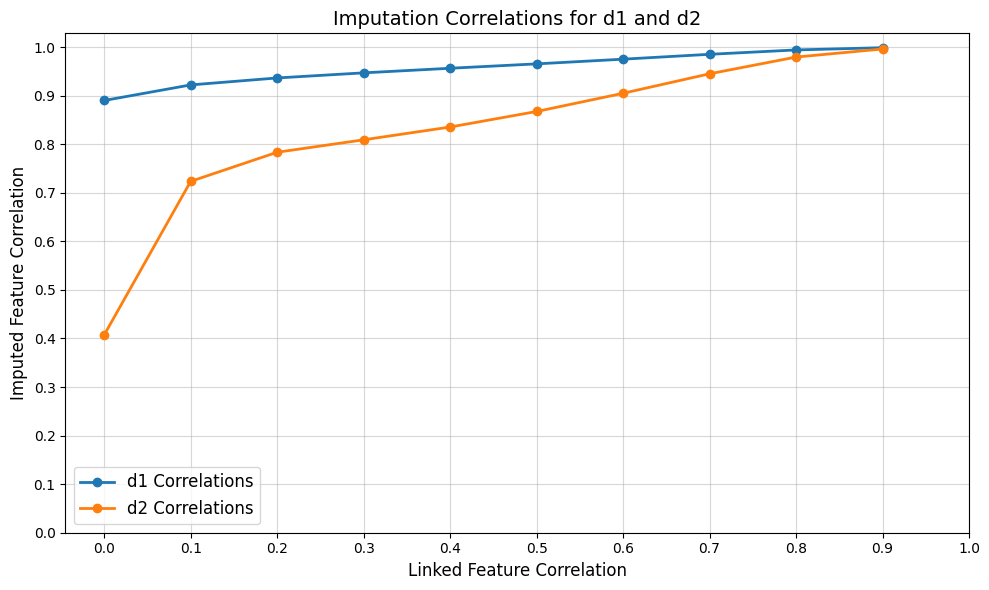

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Correlation values for x-axis (e.g., 0.0 to 0.9 in steps of 0.1)
x_values = np.arange(0, 1.0, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, impute_corr[0,:], label='d1 Correlations', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, impute_corr[1,:], label='d2 Correlations', marker='o', linestyle='-', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Linked Feature Correlation', fontsize=12)
plt.ylabel('Imputed Feature Correlation', fontsize=12)
plt.title('Imputation Correlations for d1 and d2', fontsize=14)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(alpha=0.5)

# Customize x-axis and y-axis ticks
plt.xticks(np.arange(0, 1.1, 0.1))  # x-axis ticks from 0 to 1 with a step of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))

plt.savefig("/Users/luosanj/Desktop/figures/celLink/simu_imputr_corr.pdf")
# Show the plot
plt.tight_layout()
plt.show()



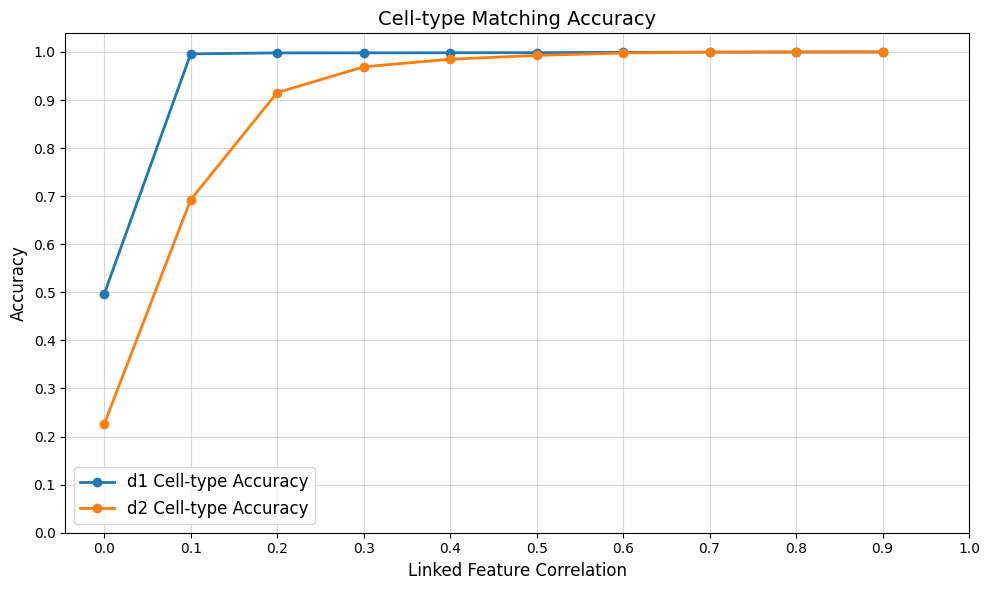

In [118]:
# Correlation values for x-axis (e.g., 0.0 to 0.9 in steps of 0.1)
x_values = np.arange(0, 1.0, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ct_acc[0,:], label='d1 Cell-type Accuracy', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, ct_acc[1,:], label='d2 Cell-type Accuracy', marker='o', linestyle='-', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Linked Feature Correlation', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Cell-type Matching Accuracy', fontsize=14)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(alpha=0.5)

# Customize x-axis and y-axis ticks
plt.xticks(np.arange(0, 1.1, 0.1))  # x-axis ticks from 0 to 1 with a step of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))
plt.savefig("/Users/luosanj/Desktop/figures/celLink/simu_impute_ctacc.pdf")
# Show the plot
plt.tight_layout()
plt.show()

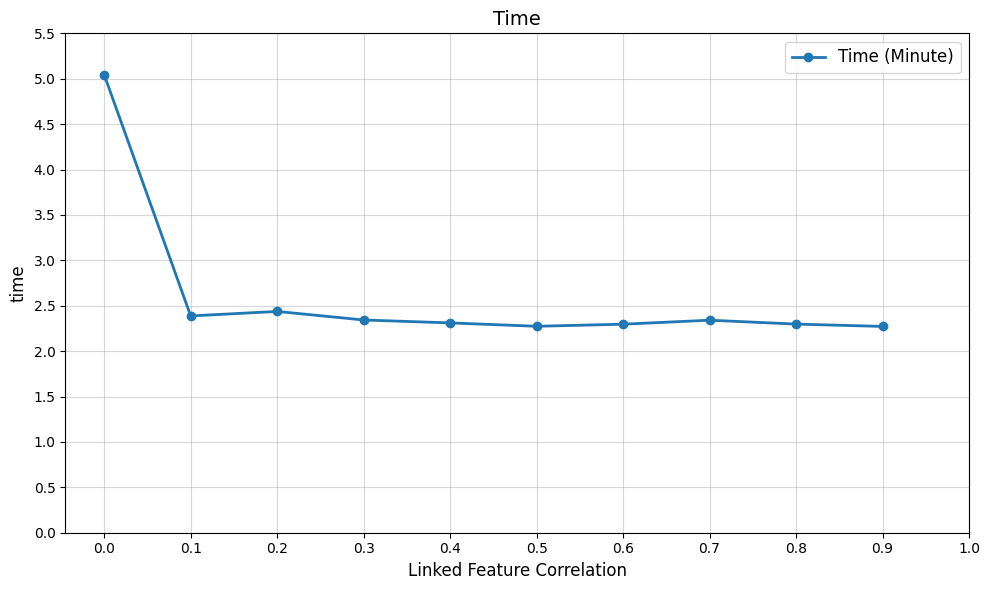

In [117]:
# Correlation values for x-axis (e.g., 0.0 to 0.9 in steps of 0.1)
x_values = np.arange(0, 1.0, 0.1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, time_loop, label='Time (Minute)', marker='o', linestyle='-', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Linked Feature Correlation', fontsize=12)
plt.ylabel('time', fontsize=12)
plt.title('Time', fontsize=14)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(alpha=0.5)

# Customize x-axis and y-axis ticks
plt.xticks(np.arange(0, 1.1, 0.1))  # x-axis ticks from 0 to 1 with a step of 0.1
plt.yticks(np.arange(0, 6, 0.5))

plt.savefig("/Users/luosanj/Desktop/figures/celLink/simu_time.pdf")
# Show the plot
plt.tight_layout()
plt.show()

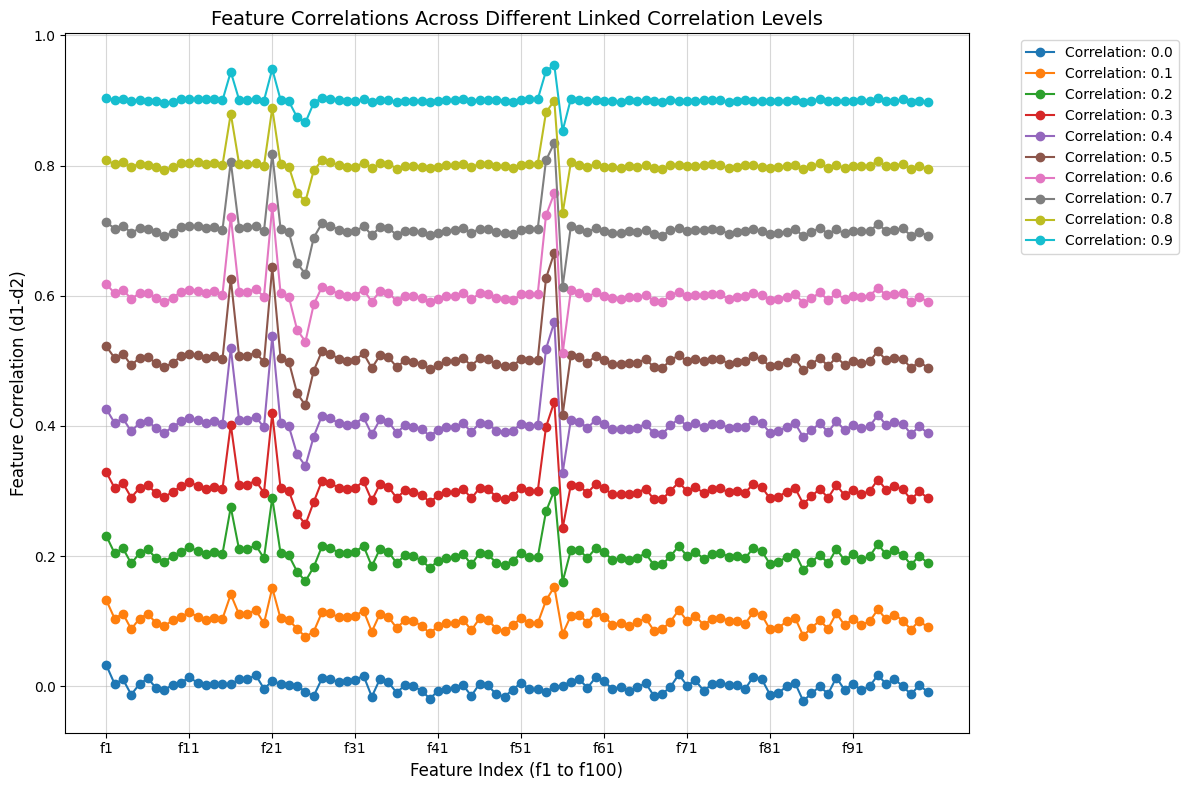

In [120]:
# Prepare the plot
plt.figure(figsize=(12, 8))

# Generate 10 lines, one for each correlation_df
for key, corr_df in dict_unscaled_feature_corr.items():
    # Extract diagonal values (d11-d21, ..., d1100-d2100 correlations)
    diagonal_correlations = np.diag(corr_df.values)
    plt.plot(
        range(1, 101),  # Feature indices (1 to 100)
        diagonal_correlations, 
        label=f'Correlation: {key}', 
        marker='o', 
        linestyle='-'
    )

# Add labels, title, and legend
plt.xlabel('Feature Index (f1 to f100)', fontsize=12)
plt.ylabel('Feature Correlation (d1-d2)', fontsize=12)
plt.title('Feature Correlations Across Different Linked Correlation Levels', fontsize=14)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Customize x-axis ticks to show f1 to f100
plt.xticks(ticks=np.arange(1, 101, 10), labels=[f'f{i}' for i in range(1, 101, 10)], fontsize=10)


plt.savefig("/Users/luosanj/Desktop/figures/celLink/simu_rawfeature_corr.pdf")
# Adjust layout and grid
plt.tight_layout()
plt.grid(alpha=0.5)

# Show the plot
plt.show()


[(1000, 100), (1000, 100)]


Text(0.5, 23.38159722222222, 'Protein')

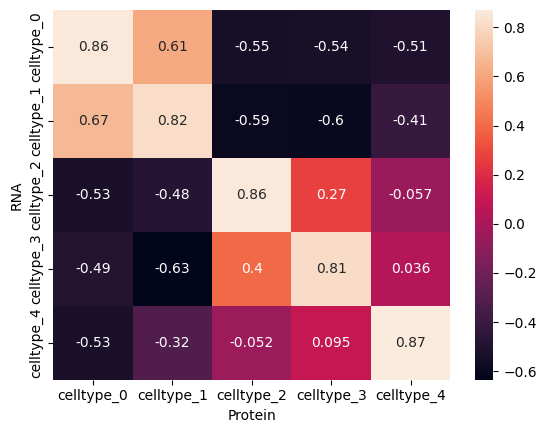

In [82]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

data = simulate_multimodal_data(
            n_cells=1000,
            cell_type_similarity_matrix=similarity_matrix,
            linked_correlation= 0.1
        )
        
# Calculate correlations per cell type
shared_features = data['d1_shared'].var_names
cell_types = data['d1_shared'].obs['cell_type'].unique()

d1_adata = data['d1_adata']
d2_adata = data['d2_adata']
d1_shared = data['d1_shared']
d2_shared = data['d2_shared']

# Make sure no column is static
mask = (
    (d1_shared.X.std(axis=0) > 0.05) 
    & (d2_shared.X.std(axis=0) > 0.05)
)
d1_shared = d1_shared[:, mask].copy()
d2_shared = d2_shared[:, mask].copy()
print([d1_shared.shape,d2_shared.shape])
        
        
cts = np.unique(d1_shared.obs['cell_type'])
ct_sim = np.zeros(shape = [len(cts), len(cts)])
for i in range(len(cts)):
     for j in range(len(cts)):
         adata_d1_filtered_ct = d1_shared[d1_shared.obs['cell_type'] == cts[i]].copy()
         expression_matrix_d1_ct = adata_d1_filtered_ct.X
         average_profile_d1_ct = np.mean(expression_matrix_d1_ct, axis=0)
        
         adata_d2_filtered_ct = d2_shared[d2_shared.obs['cell_type'] == cts[j]].copy()
         expression_matrix_d2_ct = adata_d2_filtered_ct.X
         average_profile_d2_ct = np.mean(expression_matrix_d2_ct, axis=0)

         sim = cosine_similarity(average_profile_d1_ct.reshape(1, -1), average_profile_d2_ct.reshape(1,-1))
         ct_sim[i, j] = sim
sns.heatmap(ct_sim, annot = True, yticklabels=cts, xticklabels=cts)
plt.ylabel('d1')
plt.xlabel('d2')

# test on datasets with large sample size

In [124]:
data = simulate_multimodal_data(
            n_cells=100000,
            cell_type_similarity_matrix=similarity_matrix,
            linked_correlation= 0.5
        )

n_types = 5
similarity_matrix = np.eye(n_types)
# High similarity between types 0 and 1
similarity_matrix[0, 1] = similarity_matrix[1, 0] = 0.8
# Medium similarity between types 2 and 3
similarity_matrix[2, 3] = similarity_matrix[3, 2] = 0.5
# Low similarity between types 3 and 4
similarity_matrix[3, 4] = similarity_matrix[4, 3] = 0.3
        
# Calculate correlations per cell type
shared_features = data['d1_shared'].var_names
cell_types = data['d1_shared'].obs['cell_type'].unique()

d1_adata = data['d1_adata']
d2_adata = data['d2_adata']
d1_shared = data['d1_shared']
d2_shared = data['d2_shared']

# Make sure no column is static
mask = (
    (d1_shared.X.std(axis=0) > 0.05) 
    & (d2_shared.X.std(axis=0) > 0.05)
)
d1_shared = d1_shared[:, mask].copy()
d2_shared = d2_shared[:, mask].copy()
print([d1_shared.shape,d2_shared.shape])

# add time tracker
start_time = time.time()

cellink = Cellink(full_ann1 = d1_adata, full_ann2 = d2_adata, shared_ann1 = d1_shared, shared_ann2 = d2_shared)
cellink = Cellink(full_ann1 = d1_adata, full_ann2 = d2_adata, shared_ann1 = d1_shared, shared_ann2 = d2_shared)
arr = [d1_shared, d2_shared]
cellink.split_into_batches(arr, 10000, seed = 100)
cellink.alignment(wt1 = 0.5, wt2 = 0.5, reg = 0.005, lambd = 0.005, reg_m1=(0.01, 40), reg_m2 = (40, 0.01))
d1_aligned_d2, d1_predict_ct, d2_aligned_d1, d2_predict_ct = cellink.synchronize_imputed_to_initial()

d1_source_ct = d1_adata.obs['cell_type']
d2_source_ct = d2_adata.obs['cell_type']

d1_corr = metric.feature_imputation_accuracy_corr(m1_feature = d1_adata[d2_source_ct == d2_predict_ct, :].X, 
                                                m2_aligned_feature1 = d2_aligned_d1[d2_source_ct == d2_predict_ct, :])
d2_corr = metric.feature_imputation_accuracy_corr(m1_feature = d2_adata[d1_source_ct == d1_predict_ct, :].X, 
                                                        m2_aligned_feature1 = d1_aligned_d2[d1_source_ct == d1_predict_ct, :])

# End timer and print duration
end_time = time.time()
duration_minutes = (end_time - start_time) / 60

print(d1_corr, '\n')
print(d2_corr, '\n')

print('d1 ct acc:', sum(d1_source_ct == d1_predict_ct) / len(d1_predict_ct), '\n')
print('d2 ct acc:', sum(d2_source_ct == d2_predict_ct) / len(d2_predict_ct), '\n')

print(duration_minutes, 'minutes!')

[(100000, 100), (100000, 100)]
Cell annotations are provided. Perform Iteratively OT!
Cell annotations are provided. Perform Iteratively OT!
The first modality is split into 10 batches, and max batch size is 10000.
The second modality is split into 10 batches, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0', '1<->1', '2<->2', '3<->3', '4<->4', '5<->5', '6<->6', '7<->7', '8<->8', '9<->9'].
Now at batch 0<->0...
36 cells from Modality X are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 5 iterations with cell-type matching accuracy 99.78%! 

There are 22 unmatched samples and 9978 matched samples in data1!

61 cells from Modality Y are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 2 iterations with cell-type matching accuracy 99.51%! 

There are 49 unmatched samples and 9951 matched samples in data2!

Now at batch 1<->1...
39 cells from Modali